<a href="https://colab.research.google.com/github/layeleomehta/Self-Driving-Car-Simulation/blob/master/Self_Driving_Car_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/rslim087a/track
!ls track
!pip3 install imgaug
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 30.04 MiB/s, done.
Checking out files: 100% (12160/12160), done.
driving_log.csv  IMG


Using TensorFlow backend.


- Cloning image data collected from Rayan Slim's github. The data was collected by the simulator by manually driving the car three rounds forward and three backwards. 
- Installing and importing several libraries. 


In [2]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


- Using the OS library to interface with underlying operating system. 
- The 'datadir' string is the name of the parent directory of Rayan Slim's data. All of the image data, and the csv file is stored within this 'track' directory. 
- Using pandas to read the csv file under the 'track' parent directory. Then setting the 'names' argument to the columns array that was defined. 
- Manipulating the column width. 
- The 'data' variable now has read and stored the entire csv file containing the images and their corresponding car property values (steering, throttle, etc). 
- Using head() function to display the first 5 elements in the 'data' variable. The default is 5, which is why the number of rows is not specified. 

In [3]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


- 'path_leaf()' function is using the ntpath library to separate the path into a head and tail component. Then it's returning just the tail component, to eliminate the extraneous directory paths. 
- The 'path_leaf()' function is applied to the center, left and right images, and the first 5 elements in the changed 'data' variable are shown. 

array([-0.96, -0.88, -0.8 , -0.72, -0.64, -0.56, -0.48, -0.4 , -0.32,
       -0.24, -0.16, -0.08,  0.  ,  0.08,  0.16,  0.24,  0.32,  0.4 ,
        0.48,  0.56,  0.64,  0.72,  0.8 ,  0.88,  0.96])

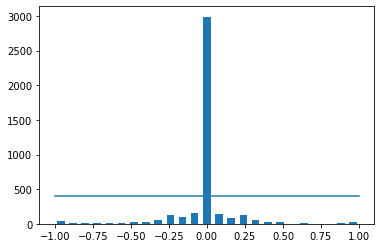

In [4]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
center

- Using the numpy library, a histogram is plotted showing the frequency of the steering data categorized into 25 bins, according to the 'num_bins' variable. The return values are stored in the 'hist' variable (which stores the histogram, and the bins variable (which returns the length of the bin edges). 
- The center' variable centers the steering data around 0. This is important, as 0 means that the car is not steering. 
- This newly centered data is plotted on a histogram using the 'bar()' function from the matplotlib pyplot library. The centered data is a range of steering values, plotted along the x axis of the histogram. 
- Looking at the frequency distribution of steering values, since there are a lot of zeroes, this can bias the car towards steering straight all the time (if this data is used to train the model). Therefore, a 'samples_per_bin' variable is initialized, which is used to specify the maximum number of samples each bin can have. Since every other bin has below 400 steering angle occurences, this will limit the zero values to 400. 
- To visualize this 'samples_per_bin' cutoff, the 'plot()' function is used from the matplotlib pyplot library, which plots a line from the lowest steering value to the highest steering value at a height of 400. 



total data: 4053
removed: 2590
remaining: 1463


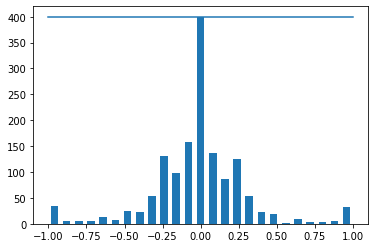

In [5]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

- In the codeblock before this one, it was decided to have a maximum of 400 samples per bin, in order to reduce bias towards the zero steering angle. The above codeblock implements an algorithm to ensure each bin has less than 400 samples. 
- The empty 'remove_list' is initialized. This is the list which will eventually hold all of the steering angle values that are to be removed from the dataset. 
- the 'j' variable in the for loop iterates through every bin, and the 'i' variable in the for loop iterates through every steering value. 
- For every bin being iterated through, an empty list named 'list_' is generated.
- For the current bin being iterated through, all steering angle values corresponding to that particular bin are stored inside 'list_'. These values are any steering angle that is >= to the current bin value, and <= the immediately next bin value. 
- For the current bin being iterated through, all the values stored within the 'list_' variable are shuffled. This is to reduce data loss from specific parts of the track when these values are eventually removed. If the list wasn't shuffled, then all information from a specific part of the track would be lost. 
- For the current bin being iterated through, the 'list_' variable is set equal to all values in the list that are after the index equaling the 'samples_per_bin' variable. All values in this updated list are then added to the 'remove_list' variable. 
- This process is done for each bin, and the 'remove_list' variable will eventually hold all of the steering angle values that are to be deleted from the data frame. 
- The corresponding values are removed using the 'drop()' function from pandas, and the updated histogram is plotted. As seen, no bin in the new histogram has more than 400 samples. 


In [28]:
print(data.iloc[30])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2018_07_16_17_11_47_287.jpg
left        left_2018_07_16_17_11_47_287.jpg  
right       right_2018_07_16_17_11_47_287.jpg 
steering    0.406934                          
throttle    1                                 
reverse     0                                 
speed       30.1064                           
Name: 49, dtype: object


- the 'load_img_steering()' function defined above creates separate arrays called 'image_paths' and 'steerings' to load only the image data and steering angles. This is done, as the 'data' array houses all of the information, so having separate arrays organizes the data better. 
- The 'image_paths' array has 3 images of the same data point (center, left, right). The 'steerings' array also has 3 steering angles corresponding the same data point, however the left and right images are 0.15 above and below the recorded steering angle value, respectively. 

Training Samples: 3511
Valid Samples: 878


Text(0.5, 1.0, 'Validation set')

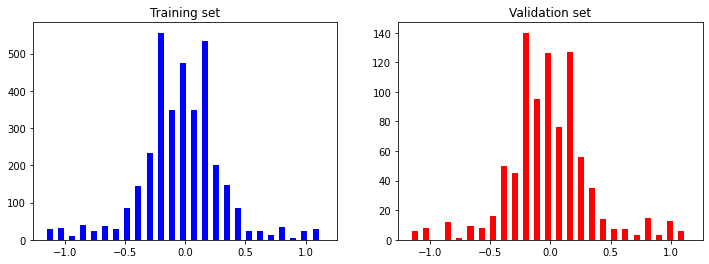

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

- The 'image_paths' and 'steerings' array are split into test and validation samples, with the x-value being the images, and the y-values being the corresponding steering angles. 
- The histograms show the frequency distribution of the steering angles for the training set and the validation set. 

Text(0.5, 1.0, 'Zoomed Image')

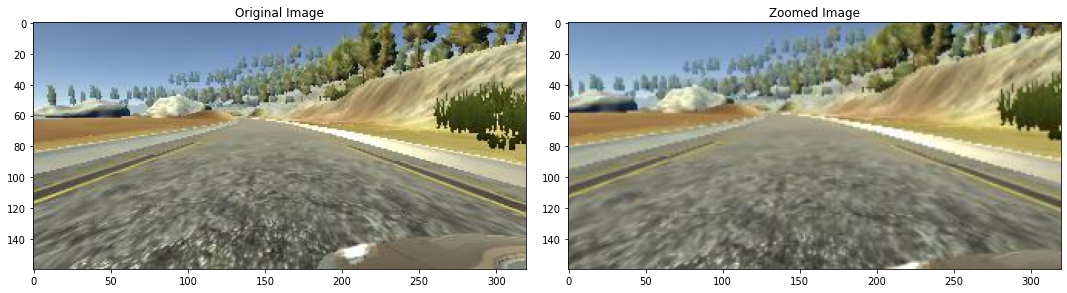

In [20]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

- This is the beginning of the data augmentation process. These images are augmented in order to avoid overfitting the data, to make the model able to generalize predictions. 
- The above block defines a 'zoom()' function which uses the imgaug library to zoom 30% into any input image. 
- A random image is chosen from the 'image_paths' array, and then depicted alongside its zoomed version for comparison. 

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.2')

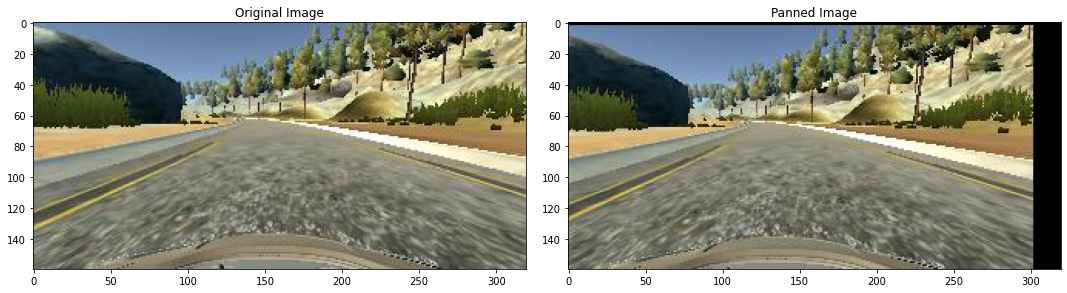

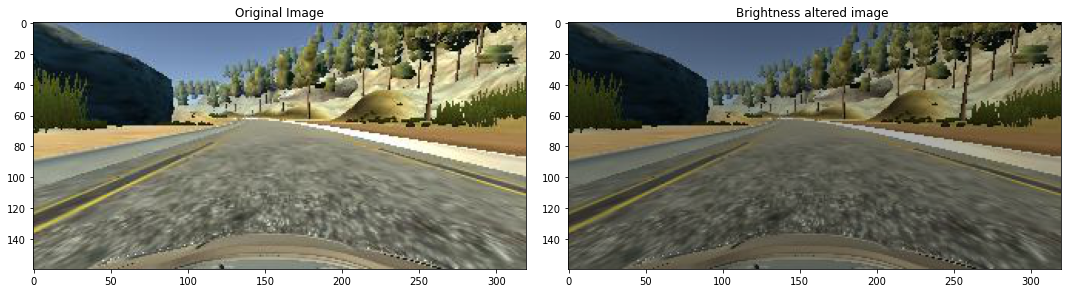

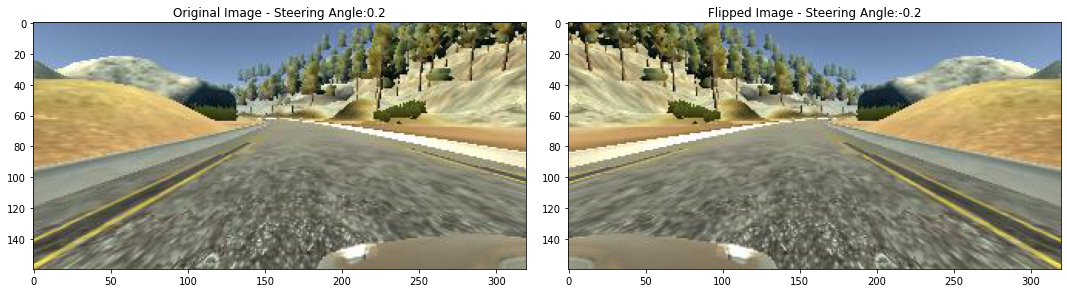

In [21]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

- Three further data augmentation functions are defined: pan(), img_random_brightness(), and img_random_flip(). 
- The 'pan()' function uses the imgaug library to offset the image. 
- The 'img_random_brightness()' function uses the imgaug library to change the brightness of the input image. 
- The 'img_random_flip' uses OpenCV to flip the image about the vertical axis. This requires the steering angle to be multiplied by -1. The function then returns both the new image and the new steering angle. 
- The above block also outputs three original images, and their augmented counterparts. 

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

- The function 'random_augment' ensures that there is only a 50% chance of executing any one of the defined data augmentation functions. 
- The above block then plots 10 random images and their randomly augmented counterparts. 

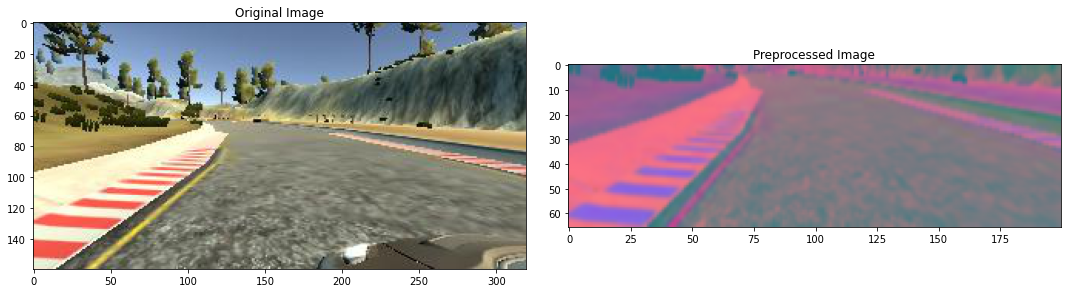

In [30]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
    
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  

- The above block defines an 'img_preprocess()' function to take in an input image and apply several image preprocessing techniques using OpenCV. The input image height is reduced to 75, and is converted to the YUV colour scheme, and a Gaussian Blur is applied to smooth image noise. The image is resized to a 200 X 66 array, and its array values are divided by 255 to reduce variation between the array data. The original and preprocessed images are then shown side-by-side for comparison. 
- ^ all images are to be pre-processed. Even the augmented images. This pre-processing step is to prepare the image for input into the neural network. 
- The 'batch_generator()' function is used to generated training and validation data in small batches, as opposed to generating all of the training and validation data and then using it to fit the machine learning model. 
- Generating the data in small batches is easier on the CPU as it is less memory-consuming, and it makes computation faster, as the computer doesn't have to allot the X_train, X_valid, y_train, y_valid data individually, and then use it in the machine learning model. 
- The 'batch_generator()' function itself takes in the following inputs: 
  - the 'image_paths' and 'steerings' arrays containing the image and steering data. 
  - takes in a specified batch size. This is the amount of data that the user wishes to generate at the given moment. 
  - takes in a boolean variable specifying whether the function is to be used to generate training or validation data. If training data is to be generated, data augmentation will be used. However, if validation data is to be generated, then the image will only be preprocessed. 


In [0]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  
  model.add(Convolution2D(64, 3, 3, activation='elu'))
#   model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))
 
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

- The above is the definition of the CNN model used to train the data. 

In [0]:
model = nvidia_model()
print(model.summary())
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

- The fit_generator() function is specifically used for batch generation of data. 
- The training and validation data are generated in batches of 100, and this function is run 300 times before the epoch is completed for the training data, and 200 times for the validation data. 
- The model fits the data for 10 epochs. 

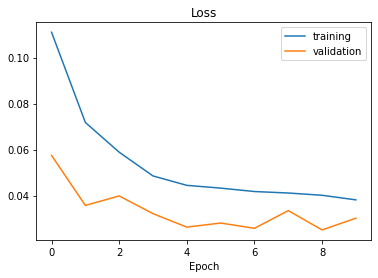

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
model.save('model.h5')
from google.colab import files
files.download('model.h5')

- The training and validation loss are plotted above. 
- The model is saved as an 'h5' file, and downloaded to the user's local machine. This is used in the future in the 'drive.py' program in order to give instructions to the Udacity simulator. 